This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [72]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [73]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'BEL',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

The "data date" is 2020-05-22 00:00:00

ADF Statistic: -1.492285
p-value: 0.537324
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


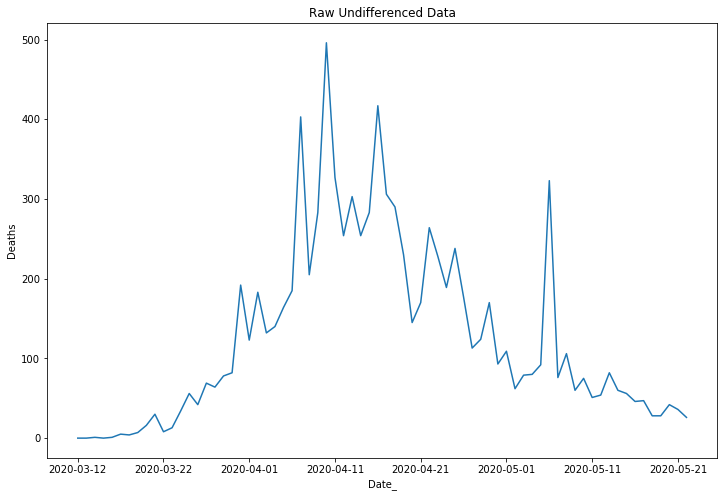

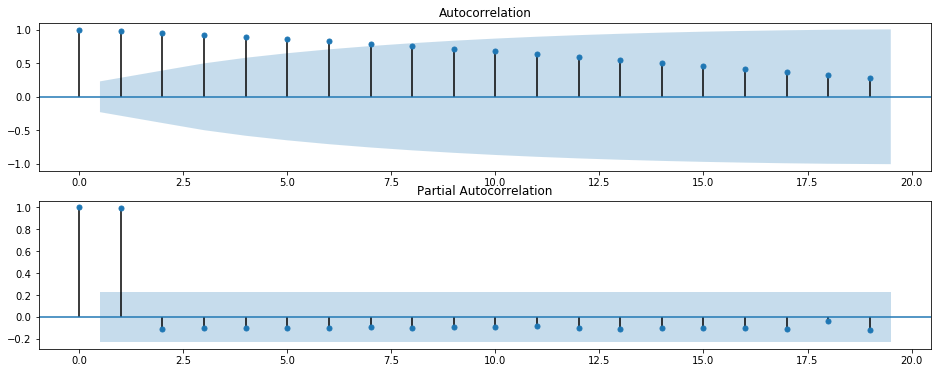

ARIMA(0, 0, 1) RMSE=3909.194
ARIMA(0, 1, 1) RMSE=113.101
ARIMA(0, 1, 2) RMSE=98.920
ARIMA(0, 2, 1) RMSE=64.744
ARIMA(0, 2, 2) RMSE=66.865
ARIMA(1, 0, 0) RMSE=162.953
ARIMA(1, 1, 0) RMSE=70.292
ARIMA(1, 2, 0) RMSE=68.068
ARIMA(1, 2, 1) RMSE=65.434
ARIMA(2, 0, 0) RMSE=71.671
ARIMA(2, 1, 0) RMSE=66.138
ARIMA(2, 2, 0) RMSE=67.938
ARIMA(2, 2, 1) RMSE=69.823
Best ARIMA(0, 2, 1) RMSE=64.744
RMSE: 64.744
                0
count   37.000000
mean   -14.129286
std     64.054616
min   -131.191474
25%    -38.054132
50%    -15.649501
75%     -2.111198
max    236.003194


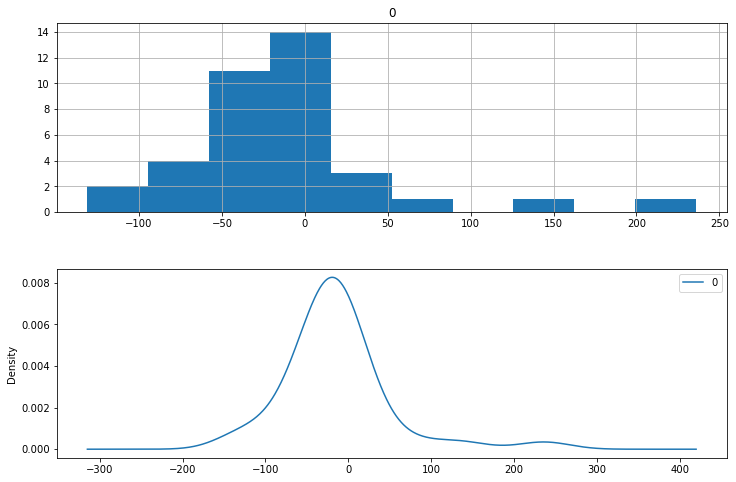


bias IS saved in arg_dict["bias"] for subsequent run is: -14.129285827438572 

RMSE: 63.183
                  0
count  3.700000e+01
mean   7.374281e-14
std    6.405462e+01
min   -1.170622e+02
25%   -2.392485e+01
50%   -1.520215e+00
75%    1.201809e+01
max    2.501325e+02


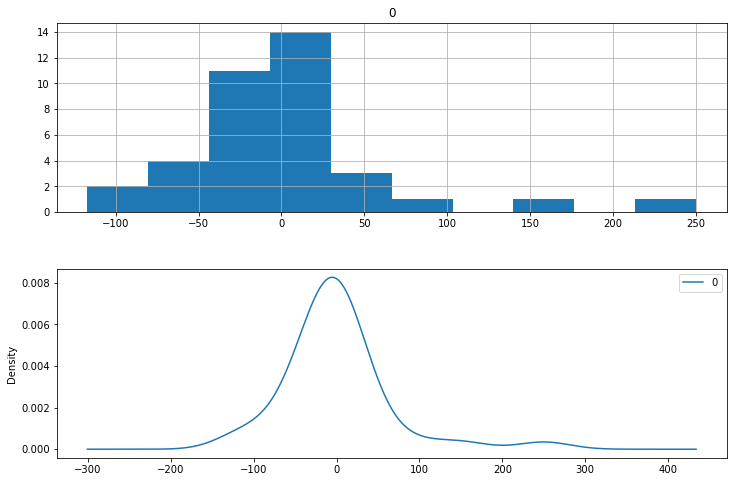


bias NOT saved in arg_dict["bias"] for subsequent run is: 7.374281365726446e-14 



In [74]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for BEL for tomorrow (input data plus 1 day) are 9,209


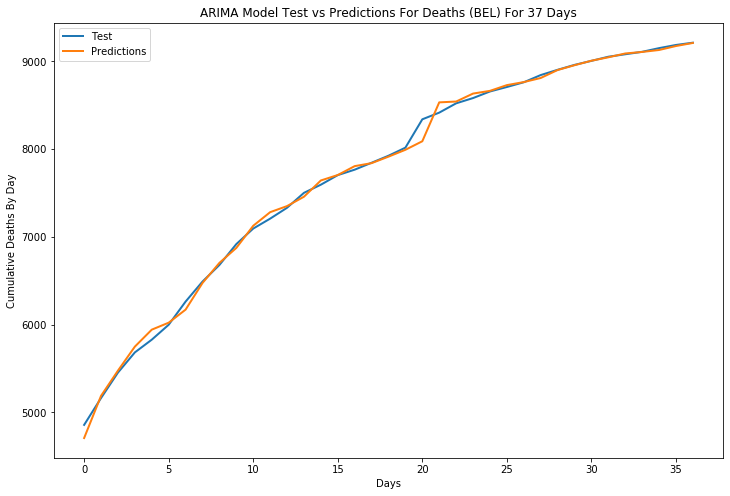

In [75]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

The BEL prediction is for 27,960 cumulative Deaths to occur by 2020-12-31 00:00:00


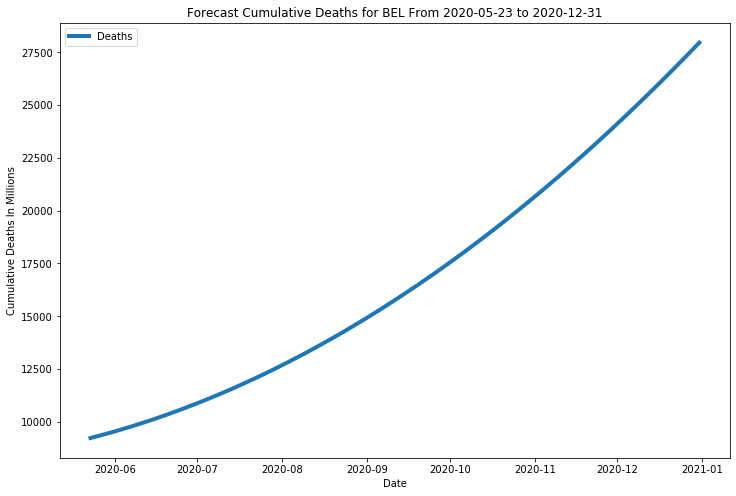

In [76]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to flatten the curve by the date indicated. We truncate the prediction at that point.

In [77]:
df['New_Daily_Deaths'] = df['Deaths'] - df['Deaths'].shift()
df.tail()

,Deaths,New_Daily_Deaths
Date_,,
2020-05-18,9080.0,28.0
2020-05-19,9108.0,28.0
2020-05-20,9150.0,42.0
2020-05-21,9186.0,36.0
2020-05-22,9212.0,26.0


In [78]:
forecast_df['New_Daily_Deaths'] = forecast_df['Deaths'] - forecast_df['Deaths'].shift()
forecast_df.head()

,Deaths,New_Daily_Deaths
Date_,,
2020-05-23,9230.0,NaN
2020-05-24,9264.0,34.0
2020-05-25,9298.0,34.0
2020-05-26,9333.0,35.0
2020-05-27,9367.0,34.0
